In [425]:
from src.process_data import *
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import string

In [426]:
plt.style.use('ggplot')

In [427]:
df = pd.read_pickle('data/processed_df.pkl')

In [428]:
stopwords_ = set(stopwords.words('english'))
punctuation_ = set(string.punctuation)

In [429]:
lemmatizer = WordNetLemmatizer()
snow = SnowballStemmer('english')

In [430]:
def remove_stopwords_and_punct(entry):
    words = str(entry).split()
    words = [word.lower() for word in words if word.lower() not in stopwords_ and word.lower() not in punctuation_]
    words = [lemmatizer.lemmatize(word, pos = 'v') for word in words]
    words = [snow.stemmer.stem(word) for word in words]
    
    return " ".join(words)
    

In [431]:
df['OBSERVED'] = df['OBSERVED'].apply(lambda x: remove_stopwords_and_punct(x))

In [432]:
drop_indices = []

for i, x in enumerate(raw_df.html):
    if 'Media Article' in x:
        drop_indices.append(i)

In [433]:
good_df = df.drop(drop_indices).reset_index()

In [434]:
good_df['report_class'].value_counts()
good_class_df = good_df.iloc[:4451]


In [435]:
y = good_class_df['report_class'].map({'(Class A)': 1, '(Class B)': 0, '(Class C)': 0 })

In [436]:
X_train, X_test, y_train, y_test = train_test_split(good_class_df['OBSERVED'],y, random_state = 0)

In [437]:
vectorizer_cv = CountVectorizer()
X_train_cv = vectorizer_cv.fit_transform(X_train)
X_test_cv = vectorizer_cv.transform(X_test)
vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)


In [438]:
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)
y_pred = clf.predict(X_test_cv)
y_pred_proba = clf.predict_proba(X_test_cv)

In [439]:
[accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), log_loss(y_test, y_pred_proba),f1_score(y_test, y_pred)]

[0.7996406109613656,
 0.7555555555555555,
 0.8733944954128441,
 2.4000125677164568,
 0.8102127659574468]

In [440]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
y_pred_proba = clf.predict_proba(X_test_cv)

In [441]:
[accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), log_loss(y_test, y_pred_proba),f1_score(y_test, y_pred)]

[0.793351302785265,
 0.7552674230145867,
 0.8550458715596331,
 2.398181304928614,
 0.8020654044750432]

In [452]:
clf = RandomForestClassifier(max_depth = 40,n_estimators = 200, random_state=0)

clf.fit(X_train_cv, y_train)
y_pred = clf.predict(X_test_cv)
y_pred_proba = clf.predict_proba(X_test_cv)

In [449]:
[accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), log_loss(y_test, y_pred_proba),f1_score(y_test, y_pred)]

[0.8023360287511231,
 0.768595041322314,
 0.8532110091743119,
 0.5154146005183121,
 0.808695652173913]

In [444]:
sorted_importances = list(np.argsort(clf.feature_importances_))
sorted_importances[-10:]

[10962, 8517, 4795, 11010, 3154, 4894, 16918, 8766, 15709, 17933]

In [445]:
words = np.array(vectorizer_cv.get_feature_names())

In [446]:

for i, v in enumerate(np.flip(sorted_importances[-20:])):
    print(f'{words[v]} : {clf.feature_importances_[v]}')

tall : 0.015789027650255184
saw : 0.01492850920839183
hear : 0.011652411502273374
sound : 0.01056051318676907
creatur : 0.009709334360456375
brown : 0.008532614539963467
loud : 0.007528181300985973
cover : 0.006866546131133014
hair : 0.006586160683669683
look : 0.0061463654265284705
hairi : 0.005771370016618406
arm : 0.0053436219294853175
turn : 0.005267416701247152
feet : 0.005109432101468217
face : 0.0050651597858051515
color : 0.004621967009879105
stand : 0.004181725718824786
upright : 0.004141170543728296
scream : 0.004020441907095746
run : 0.0038752787722868554


In [447]:
log_losses = []
for i in range(20, 40):
    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train_cv, y_train)
    y_pred_proba = clf.predict_proba(X_test_cv)
    log_losses.append(log_loss(y_test, y_pred_proba))
    

KeyboardInterrupt: 

In [500]:
dumb_words = np.array(['saw','hear','run','scream','tall','brown','loud','cover','hairi','creatur', 'hear scream loud'])

In [501]:
dumb_test = vectorizer_cv.transform(dumb_words)

In [502]:
dumb_preds = clf.predict(dumb_test)
dumb_probas = clf.predict_proba(dumb_test)

<BarContainer object of 11 artists>

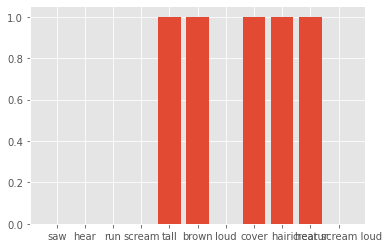

In [503]:
plt.bar(dumb_words,dumb_preds)

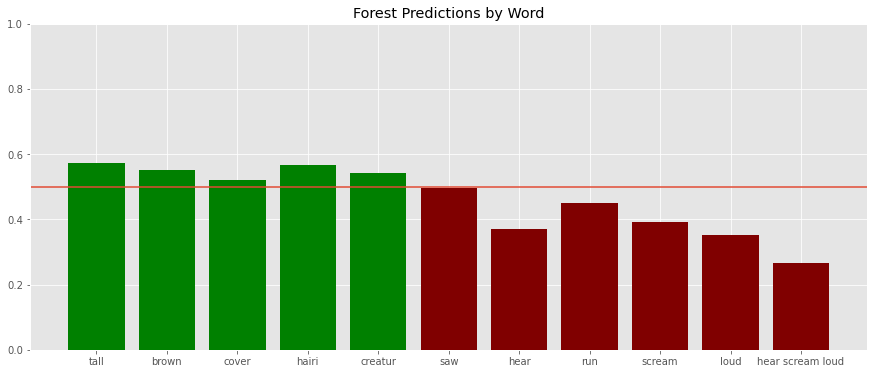

In [524]:
fig, ax = plt.subplots(figsize = (15,6))
ax.bar(dumb_words[dumb_probas[:,1]> 0.5], dumb_probas[dumb_probas[:,1] > 0.5][:,1], color = 'g')
ax.bar(dumb_words[dumb_probas[:,1]< 0.5], dumb_probas[dumb_probas[:,1] < 0.5][:,1], color = 'maroon')

ax.set_ylim(0,1)
ax.axhline(0.5)
ax.set_title('Forest Predictions by Word')
plt.savefig('img/forest_pred_by_word')

In [505]:
sum(dumb_test.toarray()[-1])

3